# Analyze field of multiple two-galaxy blends

A catsim-like catalog with multiple two-galaxy blends with different orientations and extent of overlap was previously generated. This was then provided as input to the [DESC Weak Lensing Deblending Package](http://weaklensingdeblending.readthedocs.io/en/latest/index.html) (hereafter WLD) and the ouput image analyzed with LSST DM science pipeline (v14.0). We look at the truth catalog (WLD) and DM output catalog below.

In [1]:
import numpy as np
from astropy.table import Table, Column
from scipy import spatial
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio

plt.rc('image', origin='lower',
       interpolation='none')
plt.rc('figure.subplot', wspace=0.3)
plt.rc('figure.subplot', hspace=0.3)

data_dir = "/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/two_gal_blend_data/" 

### Input Catalog Description:
The catsim-like catalog was created to represent a 576 $\times$ 2880 pixel field, as a combination of 720 postage stamps (each 48 $\times$ 48 pixels). 

20 galaxies were selected at random from the one-square-degree catsim catalog with i band magnitude $<$24.

Each postage stamp consits of two *identical* galaxies (from the 20 selected galaxies) with different orientations and with different distance between them. The pair centers have the same y coordinate, thereby difference in centers is just the difference in x cordinate of the centers.
Postage stamps are created for 3$\times$ 3 $\times$ 4 = 36 pairs with the following variations:
1. Distance between pair centers = 2, 4 and 6 times the semimajor axis
1. Angle between major axes of the two galaxies = 0, 45 and 90 deg
1. Each galaxy rotated by 0, 45, 90 and 135 degrees. 

Every distinct galaxy pair will have 3 rows of postage stamps each with a specific angle between major axes. 
Each row has 12 columns: the 4 rotations of the galaxies for each of the 3 distances.



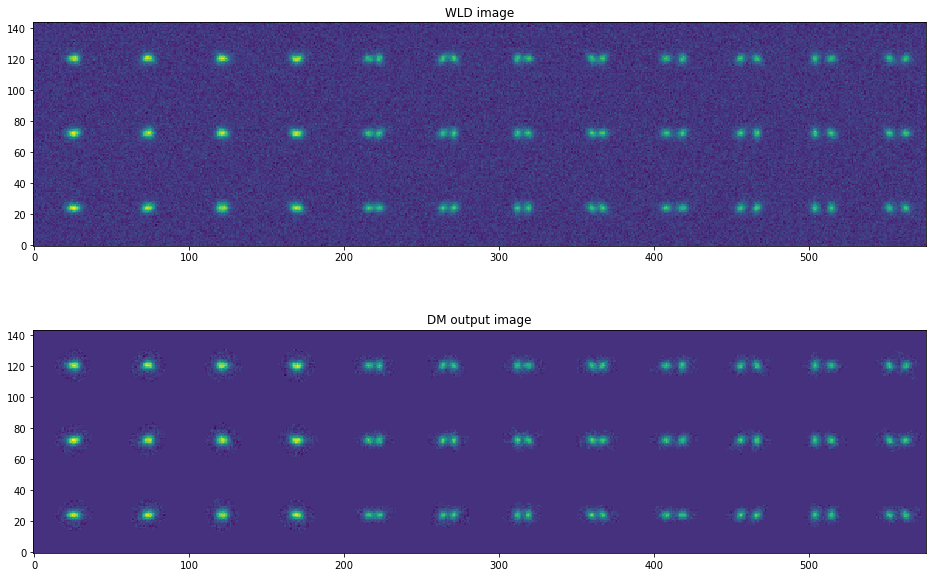

In [2]:
# Postage stamps of one galaxy pair 

dm_image = fitsio.read(data_dir + 'mock_gal_pairs_dm_image.fits',ext=0)
wld_image = fitsio.read(data_dir + 'mock_gal_pairs_wldeb_noise.fits',ext=0)
plt.figure(figsize=[16,10])
plt.subplot(2,1,1)
plt.imshow(wld_image[0:3*48])
plt.title("WLD image")
plt.subplot(2,1,2)
plt.imshow(dm_image[0:3*48])
plt.title("DM output image")

In [3]:
# Read the output from WLD
wld_out = Table.read(data_dir + 'mock_gal_pairs_wldeb.fits',
                     format= 'fits', hdu=1)

In [4]:
# Read in the output from DM
dm_all = Table.read(data_dir + 'mock_gal_pairs_dm.fits',
                    format= 'fits', hdu=1)

### Quantify "blendedness"
WLD has a parameter to denote how "blended" a given galaxy is:
- `Purity`: Purity is defined as
$$purity = \frac{\sum_p s_{ip}\cdot s_{ip}}{\sum_p (s_{ip}\cdot \sum_j s_{jp})} $$
where the sums over $p$ are over all pixels within the overlapping group and the sum over $j$ is over all sources with any overlap with source $i$, including $i$ itself. Purity is then a ratio of weighted flux estimates over pixels where we treat the object as being isolated in the numerator and include overlaps in the denominator, and use the true profile of source $i$ for the weights in both cases. 
By construction, $0 < purity \le 1$ with $ purity = 1$ for perfectly isolated sources (grp_size=1).

There is an equivalent parameter computed by DM: 
- Blendedness parameter: name= `base_Blendedness_old`, "blendedness from dot products:(child.dot(parent)/child.dot(child) - 1)"  
$$Blendedness = \frac{\sum_p (s_{ip}\cdot \sum_j s_{jp})} {\sum_p s_{ip}\cdot s_{ip}} - 1 $$
sum over $j$ is over all sources with any overlap with source $i$,*NOT* including $i$ itself


$$purity = 1/(1 + Blendedness)$$

In [5]:
# Compute the purity based on the DM output
purity = 1/(1 + dm_all['base_Blendedness_old'])
col = Column(purity, name="purity")
dm_all.add_column(col)

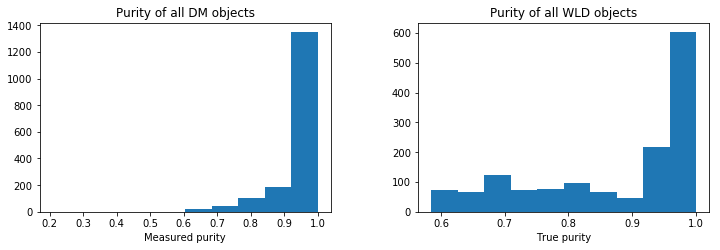

In [7]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.hist(dm_all['purity'])
plt.title("Purity of all DM objects")
plt.xlabel("Measured purity")
plt.subplot(2,2,2)
plt.hist(wld_out['purity'])
plt.title("Purity of all WLD objects")
plt.xlabel("True purity")

### Blending heirarchy
A “family” refers to a group of blended objects, and “child” refers to a particular deblended object within a family. A “parent” is created for each family, representing the alternate hypothesis that the blend is actually a single object. Blends may be hierarchical; a child at one level may be a parent at the level below. For each parent, `deblend_nChild` gives the number of children an object has.

The output DM catalog saves measurements for both parents and children. Catalog entries with `deblend_nChild`=0 are only children; catalog entries with `parent`=0 are only parents. WLD defines a group as a set of galaxies that have at least one pixel overlap, and computes the number of members in the group as `grp_size` . We compute an equivalent value for the DM output by counting the number of children in the parent of a given entry, and adding the number of children in the parent of the parent(if any) and so on till `parent`=0. 

In [8]:
def get_grp_size(cat, id_in):
    """Returns number of DM children connected to input source.
    Computes sum of nuber of children of a source's parent and its parent
    and henceforth till an isolated parent is reached"""
    num = 0
    row = cat[cat['id'] == id_in]
    if row['parent'] == 0:
        return 1
    while (row['parent'] != 0):
        new_id = int(row['parent'])
        row = cat[cat['id'] == new_id]
        num += int(row['deblend_nChild'])
    return num

grp_size = np.zeros(len(dm_all))
for i in range(len(dm_all)):
    grp_size[i] = get_grp_size(dm_all, dm_all["id"][i])
col = Column(grp_size, name="grp_size")
dm_all.add_column(col)

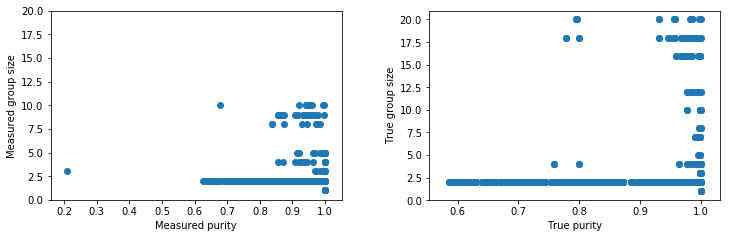

In [12]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.scatter(dm_all['purity'], dm_all['grp_size'])
plt.xlabel("Measured purity")
plt.ylabel("Measured group size")
plt.ylim([0,20])
plt.subplot(2,2,2)
plt.scatter(wld_out['purity'], wld_out['grp_size'])
plt.xlabel("True purity")
plt.ylabel("True group size")

In [13]:
# We can separate out just the children by selecting `deblend_nChild`=0
dm_out = dm_all[dm_all["deblend_nChild"]==0]

### Match true and measured
To compare input and output parameters, we match the object centers of the DM output to the input catalog.
For a given DM entry we do this by finding the nearest true center within a tolerance value (here 5 pixels).

Something to think about: Do you expect this method to be accurate and robust?

In [14]:
def get_match(tru_cat, det_cat,
              im_shape, tolerance=5):
    """Returns index of true catalog that are the closest 
    match to the detected catalog centers within the tolerance
    limit.
    """
    # Get x and y coordinates of WLD catalog objects
    z1 = np.zeros((len(tru_cat),2)) 
    z1[:,0] = np.array(tru_cat['dx']/0.2 + (im_shape[1]-1)/2.)
    z1[:,1] = np.array(tru_cat['dy']/0.2 + (im_shape[0]-1)/2.)
    z1_tree = spatial.KDTree(z1)
    # Get x and y coordinates of DM output catalog objects
    z2 = np.zeros((len(det_cat),2)) 
    z2[:,0] = det_cat['base_GaussianCentroid_x']
    z2[:,1] = det_cat['base_GaussianCentroid_y']
    match = z1_tree.query(z2, distance_upper_bound=tolerance)
    return match

match = get_match(wld_out, dm_out,dm_image.shape)

Some of the DM outputs might be spurious detections, so we remove the DM children with nan flux

In [29]:
select_dm, = np.where((~np.isinf(match[0])) &(~np.isnan(dm_out["base_SdssShape_flux"])))
select_wld = match[1][select_dm]
match_dm = match[1][~np.isinf(match[0])]
print (f"Number of detected children is {len(dm_out)} out of {len(wld_out)} simulated galaxies")
print (f"Number of true matched detections is {len(select_dm)}")

Number of detected children is 1230 out of 1440 simulated galaxies
Number of true matched detections is 1180


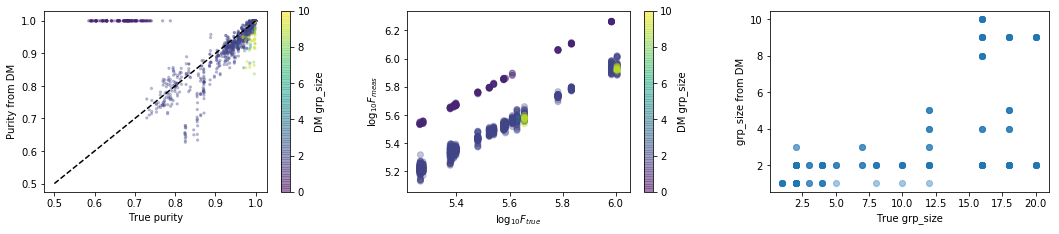

In [21]:
plt.figure(figsize=[18,12])
plt.subplot(3,3,1)
c=['r', 'g', 'b', 'y', 'k', 'm', 'b', 'y', 'k', 'm']
plt.scatter(wld_out['purity'][select_wld],
            dm_out['purity'][select_dm],
            c=dm_out["grp_size"][select_dm],
            vmin=0, vmax=10, alpha=0.3, s=5)
plt.plot([0.5,1], [0.5,1], 'k--')
plt.ylabel("Purity from DM")
plt.xlabel("True purity")
cbar = plt.colorbar()
cbar.set_label(label='DM grp_size',size=10)
plt.subplot(3,3,2)
plt.scatter(np.log10(wld_out['flux'][select_wld]),
            np.log10(dm_out['base_SdssShape_flux'][select_dm]),
            c=dm_out["grp_size"][select_dm],
            vmin=0, vmax=10, alpha=0.3)
cbar = plt.colorbar()
cbar.set_label(label='DM grp_size',size=10)
plt.ylabel("$\log_{10}{F_{meas}}$")
plt.xlabel("$\log_{10}{F_{true}}$ ")
#lims = np.array([np.min(dm_out['base_SdssShape_flux'][select_dm]),
#        np.max(dm_out['base_SdssShape_flux'][select_dm])])
#plt.xlim(lims)
#plt.ylim(lims)


plt.subplot(3,3,3)
plt.scatter(wld_out['grp_size'][select_wld],
            dm_out['grp_size'][select_dm],
            alpha=0.4)
#plt.plot([0.5,1], [0.5,1], 'k--')
plt.ylabel("grp_size from DM")
plt.xlabel("True grp_size")


## Exercises:
- Can you explain the clump of galaxies with DM purity=1 on the top left of the first plot?
- Why are there two distinct lines in plot 2?

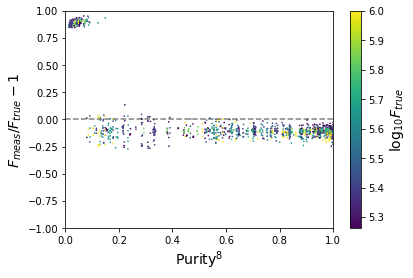

In [27]:
d_flux = ( dm_out['base_SdssShape_flux'][select_dm] - wld_out['flux'][select_wld]) / wld_out['flux'][select_wld]
plt.scatter(wld_out['purity'][select_wld]**8,d_flux,
            c=np.log10(wld_out['flux'][select_wld]),
            vmax=6, s=0.4)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.axhline(0, linestyle='--', c='k', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label(label='$\log_{10}{F_{true}}$',size=14)
plt.xlabel('Purity$^{8}$',fontsize=14)
plt.ylabel('$F_{meas}/F_{true}-1$',fontsize=14);

## Exercises:
Q) Investigate the following:
- true purity of detected objects and undetected objects
- relationship between purity and SNR estimated by WLD (Hint: Look at Pixel-Level Properties [here](http://weaklensingdeblending.readthedocs.io/en/latest/output.html#analysis-results))
- errors in centroid position measured by DM (Hint: look at get_match() function)
- relationship between purity and other blendedness parameters computed by DM (Hint: Look at catalog.schema in Process.ipynb for explanation of attributes computed by DM) 
